<a href="https://colab.research.google.com/github/juangoss/eccdum_assignments/blob/main/assignments/proyecto_estrategia_comercial_datos_grupo_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Estrategia Comercial con Datos

### Grupo 8: Martina Supatto y Juan Andrés Gossweiler

In [1]:
!pip install -q eccd_datasets

In [2]:
#import libraries
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision.transforms.v2 as transforms
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from eccd_datasets import load_images
from PIL import Image
from torchvision import models
from tempfile import TemporaryDirectory
import time
import os

torch.manual_seed(42)

## Obtener banco de imágenes de frutas y verduras

In [3]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [4]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

In [5]:
label_encoder = LabelEncoder()
cat_label = df_images['coarse_cat'].unique()
label_encoder.fit(cat_label)

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_data = self.df.iloc[idx]['image_data']
        image = load_image_data(image_data)
        label = self.df.iloc[idx]['coarse_cat']
        label = label_encoder.transform([label])[0]
        # Assuming coarse_cat column contains labels

        if self.transform:
            image = self.transform(image)

        return image, label

Normalización de datos

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
}

# Create datasets using your ImageDataset class
image_datasets = {
    x: ImageDataset(df_images[df_images['dataset'] == x], transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Now you can create DataLoaders using the datasets
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

#build dictionary with key df_images dataset and value is the count as occurens of each
dataset_sizes = {x: df_images[df_images['dataset'] == x].shape[0] for x in ['train', 'val', 'test']}

#get only df_images that have dataset column value as train. Then keep only column coearse_cat
class_names = df_images[df_images['dataset'] == 'train']['coarse_cat']

#pick available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Usamos modelo pre entrenado

In [8]:
model_ft =  models.resnet18(weights='IMAGENET1K_V1')

input_layers = model_ft.fc.in_features
output_layerse = model_ft.fc.out_features

print(f"Input layers: {input_layers}")
print(f"Output layers: {output_layerse}")

number_of_classes = df_images['coarse_cat'].nunique()
print(f"Number of classes: {number_of_classes}")

model_ft.fc = torch.nn.Linear(input_layers, number_of_classes)
input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features
print(f"Input layers: {input_last_layer}")
print(f"Output layers: {output_last_layer}")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Input layers: 512
Output layers: 1000
Number of classes: 5
Input layers: 512
Output layers: 5


Fine Tuning de modelo pre entrenado

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9473 Acc: 0.6326
val Loss: 0.3418 Acc: 0.8596

Epoch 1/24
----------
train Loss: 0.6659 Acc: 0.7407
val Loss: 0.3164 Acc: 0.8947

Epoch 2/24
----------
train Loss: 0.6070 Acc: 0.7911
val Loss: 0.2189 Acc: 0.9123

Epoch 3/24
----------
train Loss: 0.4027 Acc: 0.8607
val Loss: 0.4256 Acc: 0.8070

Epoch 4/24
----------
train Loss: 0.4168 Acc: 0.8593
val Loss: 0.3246 Acc: 0.8947

Epoch 5/24
----------
train Loss: 0.3394 Acc: 0.8800
val Loss: 0.2240 Acc: 0.9298

Epoch 6/24
----------
train Loss: 0.4126 Acc: 0.8593
val Loss: 0.9467 Acc: 0.7018

Epoch 7/24
----------
train Loss: 0.2737 Acc: 0.9081
val Loss: 0.4016 Acc: 0.8421

Epoch 8/24
----------
train Loss: 0.1923 Acc: 0.9319
val Loss: 0.3831 Acc: 0.8246

Epoch 9/24
----------
train Loss: 0.1376 Acc: 0.9511
val Loss: 0.2484 Acc: 0.8947

Epoch 10/24
----------
train Loss: 0.1941 Acc: 0.9348
val Loss: 0.4405 Acc: 0.8246

Epoch 11/24
----------
train Loss: 0.1606 Acc: 0.9467
val Loss: 0.4640 Acc: 0.8421

Ep

Funcion de predicción

In [34]:
def predict_item(model, image_data):
    was_training = model.training
    model.eval()
    img_t = data_transforms['test'](load_image_data(image_data))
    img = img_t.unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        return cat_label[preds[0].item()]

In [11]:
items_price = {'Apple':74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}

def predict_price(model, image_data):
  return items_price[predict_item(model, image_data)]

In [12]:
def cost_function(y_pred, y_real):
  if y_pred <= y_real:
    return y_real - y_pred
  return 5*(y_pred - y_real)


In [13]:
def calculate_prices_and_cost(row):
    real_price = items_price[row['coarse_cat']]
    predicted_cat = predict_item(model_ft, row['image_data'])
    predicted_price = items_price[predicted_cat]
    cost = cost_function(predicted_price, real_price)
    return pd.Series({'predicted_cat': predicted_cat, 'real_price': real_price, 'predicted_price': predicted_price, 'cost': cost})

Estimate total cost

In [35]:
df_test = df_images[df_images['dataset'] == 'test'].copy()
df_test[['predicted_cat','real_price', 'predicted_price', 'cost']] = df_test.apply(calculate_prices_and_cost, axis=1)
total_cost = df_test['cost'].sum()
print(f"Resultado de funcion de costo para dataset de prueba: ${total_cost}")

Resultado de funcion de costo para dataset de prueba: $34802


In [15]:
#count when real_price is greater than predicted_price
count_lower_price = df_test[df_test['real_price'] > df_test['predicted_price']].shape[0]
count_correct_price = df_test[df_test['real_price'] == df_test['predicted_price']].shape[0]
count_higher_price = df_test[df_test['real_price'] < df_test['predicted_price']].shape[0]

print(f"Cantidad de predicciones correctas: {count_correct_price}")
print(f"Cantidad de predicciones menores al precio real: {count_lower_price}")
print(f"Cantidad de predicciones mayores al precio real: {count_higher_price}")

Cantidad de predicciones correctas: 648
Cantidad de predicciones menores al precio real: 390
Cantidad de predicciones mayores al precio real: 284


In [16]:
count_lower_price_by_category = df_test[df_test['real_price'] > df_test['predicted_price']].groupby('coarse_cat')['coarse_cat'].count()
print(count_lower_price_by_category)

count_higher_price_by_category = df_test[df_test['real_price'] < df_test['predicted_price']].groupby('coarse_cat')['coarse_cat'].count()
print(count_higher_price_by_category)

count_correct_price_by_category = df_test[df_test['real_price'] == df_test['predicted_price']].groupby('coarse_cat')['coarse_cat'].count()
print(count_correct_price_by_category)


coarse_cat
Apple         4
Melon       304
Pear         20
Satsumas     62
Name: coarse_cat, dtype: int64
coarse_cat
Apple        14
Orange       72
Pear        192
Satsumas      6
Name: coarse_cat, dtype: int64
coarse_cat
Apple       534
Melon         2
Orange       40
Pear          4
Satsumas     68
Name: coarse_cat, dtype: int64


In [43]:
# Calculate cost by category
cost_by_category = df_test.groupby('coarse_cat')['cost'].sum()
cost_by_category

,cost
coarse_cat,
Apple,2606
Melon,6320
Orange,4840
Pear,19578
Satsumas,1458


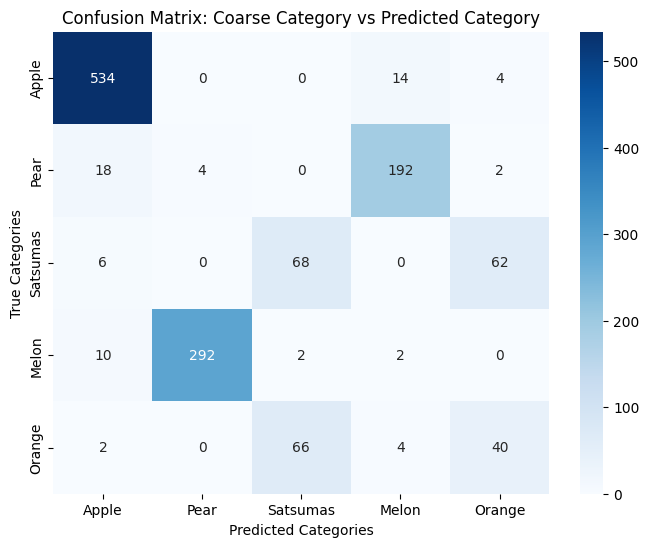

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test['coarse_cat'], df_test['predicted_cat'], labels=df_test['coarse_cat'].unique())

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_test['coarse_cat'].unique(), yticklabels=df_test['coarse_cat'].unique())

# Add labels and title
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')
plt.title('Confusion Matrix: Coarse Category vs Predicted Category')

# Show the plot
plt.show()


In [42]:
from sklearn.metrics import recall_score

# Calculate recall for each category
recall_per_category = recall_score(df_test['coarse_cat'], df_test['predicted_cat'], average=None, labels=df_test['coarse_cat'].unique())

# Print the recall for each category
for i, category in enumerate(df_test['coarse_cat'].unique()):
    print(f"Recall for category '{category}': {round(recall_per_category[i], 2)}")

accuracy = round(np.trace(cm) / np.sum(cm), 2)
print(f"Accuracy: {accuracy}")

Recall for category 'Apple': 0.97
Recall for category 'Pear': 0.02
Recall for category 'Satsumas': 0.5
Recall for category 'Melon': 0.01
Recall for category 'Orange': 0.36
Accuracy: 0.49


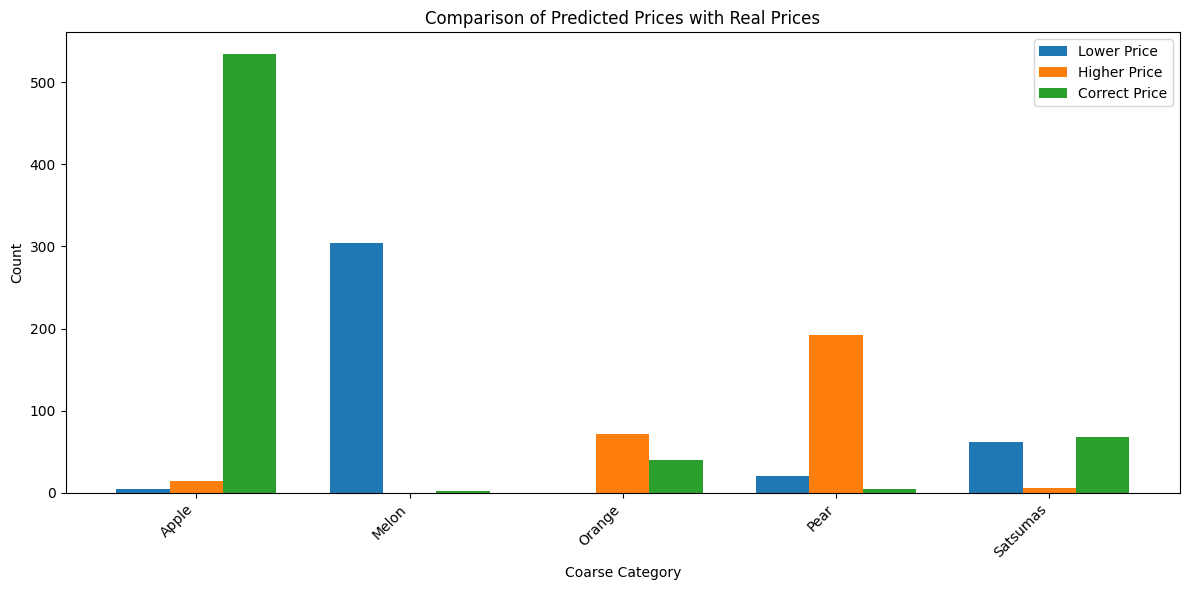

In [18]:
# Get unique categories and their positions
categories = count_lower_price_by_category.index.union(count_higher_price_by_category.index).union(count_correct_price_by_category.index)
x_pos = np.arange(len(categories))

# Create bar chart
bar_width = 0.25  # Adjust bar width if needed
plt.figure(figsize=(12, 6))

plt.bar(x_pos - bar_width, count_lower_price_by_category.reindex(categories).fillna(0), width=bar_width, label='Lower Price')
plt.bar(x_pos, count_higher_price_by_category.reindex(categories).fillna(0), width=bar_width, label='Higher Price')
plt.bar(x_pos + bar_width, count_correct_price_by_category.reindex(categories).fillna(0), width=bar_width, label='Correct Price')

# Set labels and title
plt.xlabel("Coarse Category")
plt.ylabel("Count")
plt.title("Comparison of Predicted Prices with Real Prices")
plt.xticks(x_pos, categories, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

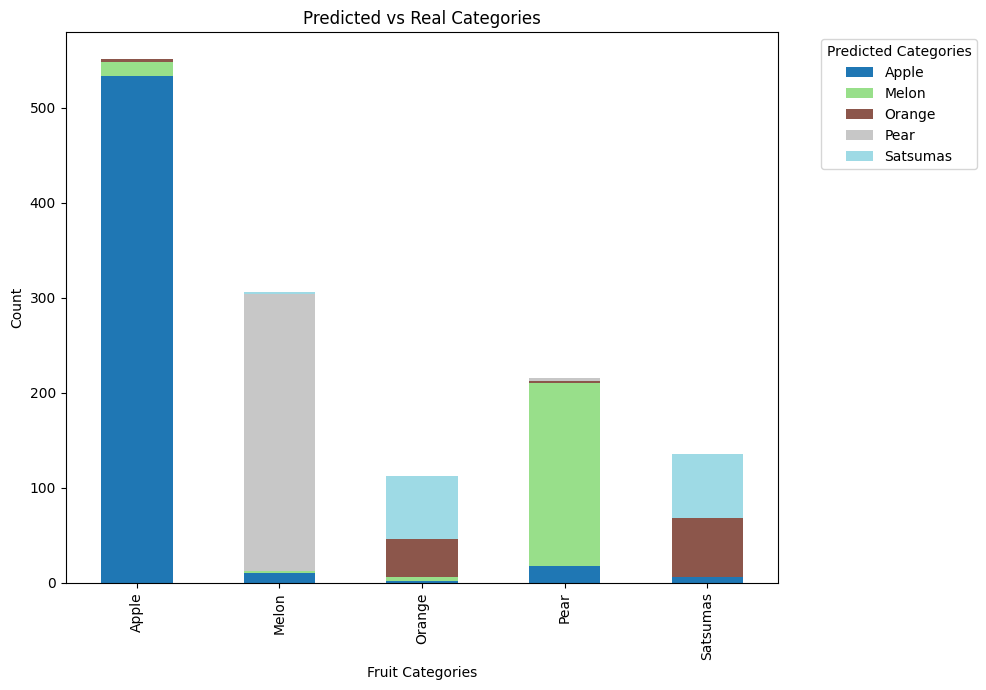

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

confusion_df = pd.crosstab(df_test['coarse_cat'], df_test['predicted_cat'])

confusion_df.plot(kind='bar', stacked=True, figsize=(10, 7), colormap="tab20")

plt.xlabel("Fruit Categories")
plt.ylabel("Count")
plt.title("Predicted vs Real Categories")
plt.legend(title="Predicted Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()